<a href="https://colab.research.google.com/github/evienmejia816-droid/Ciencia-De-Datos/blob/main/Copia_de_Laboratorio1_Incremento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# 📚 MÓDULO B — Fundamentos Conceptuales
### Bodegas de Datos · Modelos Multidimensionales · Estadística · Histogramas · Outliers · Missings
---


# 📚 MÓDULO CONCEPTUAL — Fundamentos de Datos
## Bodegas de Datos · Modelos Multidimensionales · Estadística · Distribuciones · Outliers · Datos Faltantes

> **¿Para qué sirve este módulo?**
> Antes de limpiar o modelar datos, un científico de datos necesita entender
> **cómo están organizados**, **qué forma tienen** y **qué problemas pueden tener**.
> Este módulo te da ese marco conceptual con ejemplos del dataset bancario que ya conoces.

---

### Mapa del módulo

| Sección | Tema |
|---------|------|
| **B1** | Bodegas de Datos — ¿qué son y para qué sirven? |
| **B2** | Modelo Multidimensional — hechos, dimensiones y cubos |
| **B3** | Estadísticos descriptivos — resumir datos en números |
| **B4** | Histogramas y distribuciones — la forma de los datos |
| **B5** | Valores atípicos (outliers) — datos que se salen de lo normal |
| **B6** | Datos desaparecidos (missings) — cuando la información no está |

---


## ⚙️ Configuración inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)

# ── Carga del dataset (ajusta la ruta según tu ambiente) ─────────────
ruta = "/content/drive/MyDrive/Colab Notebooks/dataset_banco.csv"
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except:
    pass

try:
    data = pd.read_csv(ruta)
    data.columns = data.columns.str.lower().str.strip()
    for col in data.select_dtypes('object').columns:
        data[col] = data[col].str.lower().str.strip()
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)
    print(f"✅ Dataset bancario cargado: {data.shape[0]:,} filas × {data.shape[1]} columnas")
except:
    # Dataset de ejemplo si no está disponible el archivo
    np.random.seed(42)
    n = 2000
    data = pd.DataFrame({
        'age'      : np.random.randint(22, 75, n),
        'job'      : np.random.choice(['admin.','blue-collar','management','retired','technician'], n),
        'marital'  : np.random.choice(['married','single','divorced'], n, p=[0.6,0.3,0.1]),
        'education': np.random.choice(['primary','secondary','tertiary','unknown'], n, p=[0.15,0.5,0.3,0.05]),
        'balance'  : np.concatenate([np.random.normal(1400, 3000, n-30),
                                     np.array([50000, 65000, -3000, -4500]*7, dtype=float)[:30]]),
        'duration' : np.abs(np.random.normal(260, 260, n)).astype(int),
        'campaign' : np.random.randint(1, 12, n),
        'pdays'    : np.random.choice([-1, 100, 200, 300], n, p=[0.8, 0.08, 0.07, 0.05]),
        'previous' : np.random.randint(0, 6, n),
        'month'    : np.random.choice(['jan','feb','mar','apr','may','jun',
                                       'jul','aug','sep','oct','nov','dec'], n),
        'y'        : np.random.choice(['yes','no'], n, p=[0.12, 0.88]),
        'default'  : np.random.choice(['yes','no'], n, p=[0.02, 0.98]),
        'housing'  : np.random.choice(['yes','no'], n, p=[0.56, 0.44]),
        'loan'     : np.random.choice(['yes','no'], n, p=[0.16, 0.84]),
    })
    print("⚠️  Dataset de ejemplo generado (archivo original no encontrado)")
    print(f"   Forma: {data.shape}")

data.head(3)


Mounted at /content/drive
✅ Dataset bancario cargado: 45,203 filas × 17 columnas


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143.00,yes,no,unknown,5,may,261.00,1,-1.00,0,unknown,no
1,44,technician,single,secondary,no,29.00,yes,no,unknown,5,may,151.00,1,-1.00,0,unknown,no
2,33,entrepreneur,married,secondary,no,2.00,yes,yes,unknown,5,may,76.00,1,-1.00,0,unknown,no


---
## 🏛️ B1. Bodegas de Datos (Data Warehouses)

### ¿Qué es una bodega de datos?

Una **bodega de datos** (Data Warehouse) es un repositorio centralizado que almacena
grandes volúmenes de datos **históricos** e **integrados** de múltiples fuentes,
diseñado específicamente para el análisis y la toma de decisiones.

> **Analogía:** Un supermercado tiene bodegas donde guarda todo su inventario organizado
> para distribución rápida. Una bodega de datos hace lo mismo pero con información.

### Base de datos operacional vs Bodega de datos

| Característica | Base de datos operacional (OLTP) | Bodega de datos (OLAP) |
|---|---|---|
| **Propósito** | Transacciones diarias | Análisis histórico |
| **Ejemplo** | Registrar una venta en tiempo real | Analizar ventas de los últimos 5 años |
| **Operaciones** | INSERT, UPDATE, DELETE | SELECT, GROUP BY, agregaciones |
| **Velocidad** | Muy rápida (milisegundos) | Más lenta (segundos/minutos) |
| **Volumen** | Miles de registros activos | Millones/billones de registros históricos |
| **Usuarios** | Cajeros, empleados, apps | Analistas, gerentes, científicos de datos |
| **Actualización** | Tiempo real | Por lotes (batch), cada hora o cada día |

### En el contexto de nuestro dataset bancario

El archivo `dataset_banco.csv` que estamos usando **proviene de una bodega de datos**
del banco. La empresa de marketing extrajo estos registros históricos para analizarlos.

```
[Sistema CRM del banco]  ──►  [ETL: Extraer-Transformar-Cargar]  ──►  [Bodega de Datos]
 (registra llamadas)           (limpia y transforma)                   (almacena histórico)
                                                                              │
                                                                              ▼
                                                                    [dataset_banco.csv]
                                                                    (lo que usamos hoy)
```

**ETL** = Extract, Transform, Load (Extraer, Transformar, Cargar)
Este proceso es exactamente lo que hemos estado haciendo en el laboratorio.


In [4]:
# ══ SIMULACIÓN DE FLUJO ETL CON NUESTRO DATASET ════════════════════
# Imaginemos que tenemos datos de TRES fuentes diferentes
# que la bodega de datos integra en una sola tabla

print("=" * 60)
print("SIMULACIÓN DE FLUJO ETL — Dataset Bancario")
print("=" * 60)

# ── FUENTE 1: Sistema CRM (datos del cliente) ────────────────────────
fuente_crm = data[['age', 'job', 'marital', 'education', 'balance', 'default']].copy()
fuente_crm.columns = ['edad', 'trabajo', 'estado_civil', 'educacion', 'saldo', 'incumplimiento']
print(f"\n📁 Fuente 1 — CRM (datos del cliente):    {fuente_crm.shape}")
print(fuente_crm.head(2).to_string())

# ── FUENTE 2: Sistema de Campañas (datos del contacto) ───────────────
fuente_campana = data[['duration', 'campaign', 'pdays', 'previous', 'month']].copy()
fuente_campana.columns = ['duracion_llamada', 'n_contactos', 'dias_desde_contacto',
                           'contactos_previos', 'mes_contacto']
# Corrección: Reemplazar -1 en 'dias_desde_contacto' por 0
fuente_campana['dias_desde_contacto'] = fuente_campana['dias_desde_contacto'].replace(-1, 0)
print(f"\n📁 Fuente 2 — Sistema de Campañas:        {fuente_campana.shape}")
print(fuente_campana.head(2).to_string())

# ── FUENTE 3: Resultado (variable objetivo) ───────────────────────────
fuente_resultado = data[['y', 'housing', 'loan']].copy()
fuente_resultado.columns = ['respuesta', 'tiene_hipoteca', 'tiene_prestamo']
print(f"\n📁 Fuente 3 — Resultados de campaña:      {fuente_resultado.shape}")
print(fuente_resultado.head(2).to_string())

# ── INTEGRACIÓN EN LA BODEGA ──────────────────────────────────────────
data_bodega = pd.concat([fuente_crm, fuente_campana, fuente_resultado], axis=1)
print(f"\n🏛️  Tabla integrada en Bodega de Datos:   {data_bodega.shape}")
print(f"   → {data_bodega.shape[1]} columnas desde {3} fuentes distintas")
print(data_bodega.head(2).to_string())

SIMULACIÓN DE FLUJO ETL — Dataset Bancario

📁 Fuente 1 — CRM (datos del cliente):    (45203, 6)
   edad     trabajo estado_civil  educacion   saldo incumplimiento
0    58  management      married   tertiary 2143.00             no
1    44  technician       single  secondary   29.00             no

📁 Fuente 2 — Sistema de Campañas:        (45203, 5)
   duracion_llamada  n_contactos  dias_desde_contacto  contactos_previos mes_contacto
0            261.00            1                 0.00                  0          may
1            151.00            1                 0.00                  0          may

📁 Fuente 3 — Resultados de campaña:      (45203, 3)
  respuesta tiene_hipoteca tiene_prestamo
0        no            yes             no
1        no            yes             no

🏛️  Tabla integrada en Bodega de Datos:   (45203, 14)
   → 14 columnas desde 3 fuentes distintas
   edad     trabajo estado_civil  educacion   saldo incumplimiento  duracion_llamada  n_contactos  dias_desde_conta

---
## 🧊 B2. Modelo de Datos Multidimensional

### La idea central: Hechos y Dimensiones

El modelo multidimensional organiza los datos en dos tipos de tablas:

**HECHOS (Facts):** La medida que queremos analizar — lo que ocurrió.
> Ejemplo: "el cliente X hizo una llamada de 350 segundos en mayo y dijo SÍ"

**DIMENSIONES (Dimensions):** El contexto que describe el hecho — el quién, cuándo, dónde.
> Ejemplo: quién (perfil del cliente), cuándo (mes, día), qué canal (teléfono/celular)

### El esquema Estrella (Star Schema)

```
                    ┌─────────────────┐
                    │  DIM_CLIENTE     │
                    │  - edad          │
                    │  - trabajo       │
                    │  - educación     │
                    │  - estado_civil  │
                    └────────┬────────┘
                             │
 ┌──────────────┐   ┌────────▼────────┐   ┌──────────────────┐
 │  DIM_TIEMPO  │   │   FACT_CAMPAÑA  │   │  DIM_PRODUCTO    │
 │  - mes       ├───►  - duracion     ◄───┤  - tiene_hipoteca│
 │  - dia       │   │  - n_contactos  │   │  - tiene_prestamo│
 └──────────────┘   │  - respuesta ✓  │   └──────────────────┘
                    │  - saldo        │
                    └────────┬────────┘
                             │
                    ┌────────▼────────┐
                    │  DIM_CANAL      │
                    │  - tipo_contacto│
                    │  - resultado_ant│
                    └─────────────────┘
```

La tabla de **HECHOS** está en el centro y se conecta con las **DIMENSIONES** a su alrededor,
formando una estrella. Por eso se llama **Esquema Estrella**.

### ¿Por qué es útil?

Permite responder preguntas de negocio como:
- ¿Cuánto duran las llamadas **por mes** y **por tipo de trabajo**?
- ¿Qué perfil de cliente tiene mayor tasa de conversión **por canal de contacto**?


In [5]:
# ══ CONSTRUYENDO UN ESQUEMA ESTRELLA CON NUESTROS DATOS ════════════

# ── Tabla de HECHOS ───────────────────────────────────────────────────
fact_campana = data[['duration', 'campaign', 'pdays', 'previous', 'y', 'balance']].copy()
fact_campana.columns = ['duracion_seg', 'n_contactos', 'dias_previos',
                         'contactos_ant', 'convirtio', 'saldo']
fact_campana['convirtio'] = (fact_campana['convirtio'] == 'yes').astype(int)
fact_campana['dias_previos'] = fact_campana['dias_previos'].replace(-1, 0)
fact_campana.index.name = 'id_llamada'

# ── Dimensión CLIENTE ─────────────────────────────────────────────────
dim_cliente = data[['age', 'job', 'marital', 'education', 'default']].copy()
dim_cliente.columns = ['edad', 'trabajo', 'estado_civil', 'educacion', 'en_mora']

# ── Dimensión TIEMPO ──────────────────────────────────────────────────
dim_tiempo = data[['month']].copy() if 'month' in data.columns else pd.DataFrame({'mes': ['unknown']*len(data)})
dim_tiempo.columns = ['mes']

# ── Dimensión PRODUCTO (servicios financieros del cliente) ────────────
dim_producto = data[['housing', 'loan']].copy() if 'housing' in data.columns else pd.DataFrame()
if not dim_producto.empty:
    dim_producto.columns = ['tiene_hipoteca', 'tiene_prestamo']

print("ESQUEMA ESTRELLA — Tablas del modelo multidimensional")
print("=" * 55)
print(f"  📊 FACT_CAMPAÑA  : {fact_campana.shape[0]:>6,} filas × {fact_campana.shape[1]} columnas")
print(f"  👤 DIM_CLIENTE   : {dim_cliente.shape[0]:>6,} filas × {dim_cliente.shape[1]} columnas")
print(f"  📅 DIM_TIEMPO    : {dim_tiempo.shape[0]:>6,} filas × {dim_tiempo.shape[1]} columnas")
if not dim_producto.empty:
    print(f"  🏦 DIM_PRODUCTO  : {dim_producto.shape[0]:>6,} filas × {dim_producto.shape[1]} columnas")

print(f"\nVista de FACT_CAMPAÑA:")
print(fact_campana.head(4).to_string())

ESQUEMA ESTRELLA — Tablas del modelo multidimensional
  📊 FACT_CAMPAÑA  : 45,203 filas × 6 columnas
  👤 DIM_CLIENTE   : 45,203 filas × 5 columnas
  📅 DIM_TIEMPO    : 45,203 filas × 1 columnas
  🏦 DIM_PRODUCTO  : 45,203 filas × 2 columnas

Vista de FACT_CAMPAÑA:
            duracion_seg  n_contactos  dias_previos  contactos_ant  convirtio   saldo
id_llamada                                                                           
0                 261.00            1          0.00              0          0 2143.00
1                 151.00            1          0.00              0          0   29.00
2                  76.00            1          0.00              0          0    2.00
3                  92.00            1          0.00              0          0 1506.00


In [6]:
# ══ ANÁLISIS MULTIDIMENSIONAL (OLAP) — CONSULTAS TIPO CUBO ════════
# Un "cubo OLAP" permite cortar y rotar los datos en múltiples dimensiones
# Aquí lo simulamos con pandas groupby

print("ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio")
print("=" * 55)

# Une las tablas (simula un JOIN en SQL / operación de cubo)
data_cubo = pd.concat([fact_campana, dim_cliente, dim_tiempo], axis=1)

# ── CONSULTA 1: Duración promedio por nivel educativo ─────────────────
print("\n📊 CORTE 1: Duración promedio de llamada por educación")
print("   (Dimensión: educación → Medida: duración)")
corte1 = data_cubo.groupby('educacion')['duracion_seg'].agg(['mean','count']).round(1)
corte1.columns = ['Duración_Promedio_seg', 'N_Llamadas']
corte1 = corte1.sort_values('Duración_Promedio_seg', ascending=False)
print(corte1.to_string())

# ── CONSULTA 2: Tasa de conversión por trabajo ────────────────────────
print("\n📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo")
print("   (Dimensión: trabajo → Medida: % que dijo SÍ)")
corte2 = (data_cubo.groupby('trabajo')['convirtio']
          .agg(['mean','count'])
          .rename(columns={'mean':'Tasa_Conversion_%','count':'N_Contactos'}))
corte2['Tasa_Conversion_%'] = (corte2['Tasa_Conversion_%'] * 100).round(1)
corte2 = corte2.sort_values('Tasa_Conversion_%', ascending=False)
print(corte2.head(6).to_string())

# ── CONSULTA 3: Tabla pivote (2 dimensiones) ──────────────────────────
print("\n📊 CORTE 3: % conversión por educación × estado civil")
print("   (2 dimensiones simultáneas — tabla pivote)")
pivot = data_cubo.pivot_table(
    values='convirtio',
    index='educacion',
    columns='estado_civil',
    aggfunc='mean'
) * 100
print(pivot.round(1).to_string())
print("\n   → Cada celda = % de clientes que dijeron SÍ")


ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio

📊 CORTE 1: Duración promedio de llamada por educación
   (Dimensión: educación → Medida: duración)
           Duración_Promedio_seg  N_Llamadas
educacion                                   
sec.                      360.00           2
secondary                 258.60       23194
tertiary                  258.40       13300
unknown                   257.40        1855
primary                   255.70        6850
unk                       217.00           2

📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo
   (Dimensión: trabajo → Medida: % que dijo SÍ)
            Tasa_Conversion_%  N_Contactos
trabajo                                   
student                 28.70          938
retired                 22.80         2264
unemployed              15.50         1303
management              13.70         9457
admin.                  12.20         5166
unknown                 11.80          288

📊 CORTE 3: % conversión por educación × est

TALLER – ANÁLISIS EXPLORATORIO DEL DATASET BANCARIO

Modalidad: Trabajo en parejas
Duración: 45 minutos
Entrega: Respuestas argumentadas + conclusiones grupales

OBJETIVO DEL TALLER
• Comprender la estructura del dataset bancario.
• Analizar la calidad de los datos.
• Identificar riesgos estadísticos.
• Desarrollar criterio para la toma de decisiones antes del modelado.

PARTE 1 – COMPRENSIÓN DEL DATASET (25 min)
Paso 1: Exploración inicial
Ejecuta:
data.info()
data.head()
data.describe()

Preguntas - Nivel descriptivo
1. ¿Cuántas observaciones y variables tiene el dataset?
R//El dataset tiene 45,203 observaciones (filas) y 17 variables (columnas).
2. ¿Qué tipos de variables existen (numéricas / categóricas)?
R// Variables numéricas
○ age (edad)
○ balance (saldo)
○ day (día del mes)
○ duration (duración de la llamada)
○ campaign (número de contactos en la campaña actual)
○ pdays (días desde el último contacto con una campaña previa)
○ previous (número de contactos previos a esta campaña)

● Variables categóricas (Tipo object):
○ job (trabajo)
○ marital (estado civil)
○ education (educación)
○ default (si tiene o no un crédito en default)
○ housing (si tiene un préstamo de vivienda)
○ loan (si tiene un préstamo personal)
○ contact (tipo de contacto de la campaña)
○ month (mes del último contacto)
○ poutcome (resultado de la campaña de marketing previa)
○ (variable objetivo: si el cliente se suscribió al depósito a término)

3. ¿Cuál crees que es la variable más importante y por qué?
R// La variable más importante es probablemente y (variable objetivo). Representa si el
cliente se suscribió o no a un depósito a término, que es el objetivo principal de la
campaña de marketing bancaria. Para el análisis de marketing de este ejemplo
(Campaña marketing), esta es la que define el éxito o fracaso de la campaña.
4. ¿Qué variables parecen tener escalas muy diferentes?
R// Observando data.describe():
● balance: Tiene un rango muy amplio, con valores que van desde -8019.00 hasta
527532.00, y una desviación estándar muy alta (3923.85).
● duration: Aunque su media es 258.04, el máximo es 4918.00
● pdays: Presenta un rango de -1.00 a 871.00
● previous: Aunque su máximo es 275.00, la mayoría de los valores son cercanos
a 0, indicando una distribución muy asimétrica y una escala diferente a balance.

5. ¿Qué variables podrían requerir transformación?
R//balance: Su distribución es muy asimétrica (min -8019, max 527532) y
probablemente tenga outliers significativos. Podría beneficiarse de transformaciones
logarítmicas o escalado, además de una inspección de los valores negativos y extremos.
● duration: Aunque es numérico, valores como -1389.00 (mínimo) parecen ser
erróneos, ya que la duración de una llamada no puede ser negativa. Este valor
debe ser investigado y posiblemente corregido (por ejemplo, a 0 o NaN) antes
de cualquier análisis o modelado. Además, su distribución amplia podría
necesitar escalado.
● pdays: Los valores de -1.00 se utilizan como un indicador de &#39;sin contacto
previo&#39;. Esto es un valor especial y podría requerir ser tratado como una
categoría o una imputación específica en lugar de un valor numérico directo, o
su conversión a 0 como ya se hizo en el esquema estrella.

● age: El valor máximo de 776.00 para la edad parece ser un outlier o un error en
los datos y debería ser investigado. Además, su distribución podría ser
asimétrica y podría requerir escalado o agrupamiento en rangos para ciertos
análisis.

Preguntas – Nivel crítico
6. ¿Qué información no puedes obtener solo con describe()?
describe() es excelente para un resumen rápido de variables numéricas, pero no te
proporciona información sobre:
● Valores únicos para cada columna (cuántos valores distintos hay).
● Conteo de valores nulos o faltantes (solo muestra el count de no nulos).
● La forma de la distribución (si es simétrica, sesgada, bimodal, etc.). Necesitas
histogramas o diagramas de caja para esto.
● Relaciones entre variables (correlaciones, dependencias).
● Los valores específicos de las variables categóricas o su frecuencia (para eso
necesitas value_counts()).
● Errores o valores anómalos más allá de los valores mínimos y máximos.

7. ¿Por qué describe() no muestra variables categóricas?
Por defecto, describe() en Pandas se enfoca en las estadísticas descriptivas que tienen
sentido para variables numéricas: promedio, desviación estándar, mínimos, máximos y
cuartiles. Estas métricas no son relevantes para datos categóricos (ej. no puedes
calcular el promedio de &#39;estado civil&#39; o &#39;tipo de trabajo&#39;).
Si quisieras un resumen de las variables categóricas, deberías usar
data.describe(include=&#39;object&#39;) o data.describe(include=&#39;all&#39;), que te mostraría la
frecuencia de la moda, el número de valores únicos, etc.

8. ¿Qué variable podría generar problemas si se analiza solo con promedios?
● balance: Tiene un rango extremadamente amplio (desde -8019.00 hasta
527532.00) y la presencia de valores negativos. Un promedio simple podría ser
engañoso, ya que la distribución es muy asimétrica y está fuertemente
influenciada por valores extremos (outliers).
● duration: Aunque la duración de una llamada es numérica, la presencia del
valor mínimo de -1389.00 es un error y un promedio incluiría este valor
incorrecto. Además, su distribución es probable que esté sesgada por llamadas

muy largas. El promedio no representaría la duración &#39;típica&#39; si hay muchos
outliers.
● pdays: Esta variable tiene un valor especial de -1.00 para indicar que el cliente
nunca fue contactado antes. Si promedias este -1 con los días reales, el
resultado no tiene un significado coherente. Es mejor tratar el -1 como una
categoría o un indicador de &#39;sin contacto previo&#39;, como ya hicimos al convertirlo
a 0 en el esquema estrella. (El valor de 776.00 en age también sería un
problema, pero ya fue identificado como un potencial outlier en la pregunta
anterior).
Las variables con outliers, valores especiales o distribuciones muy sesgadas no son bien
representadas sólo por el promedio, y requieren un análisis más profundo de su
distribución.

Paso 2: Variable objetivo (sin modelar)
Ejecuta:
data[&#39;y&#39;].value_counts()
data[&#39;y&#39;].value_counts(normalize=True)

Preguntas – Interpretación
1. ¿Cuál es la clase mayoritaria?
La clase mayoritaria es &#39;no&#39;, con 39,916 observaciones.
2. ¿Qué porcentaje representa la clase minoritaria?
La clase minoritaria es &#39;yes&#39;, que representa aproximadamente el 12% del dataset.
3. ¿Este comportamiento es realista en campañas bancarias?
Sí, este comportamiento es realista en campañas de marketing bancarias, y en general
en muchas campañas de muchos tipos. Las tasas de conversión (el porcentaje de
personas que responden positivamente o aceptan una oferta suelen ser bajas. Un 12%
es una tasa de conversión relativamente buena.
4. ¿Qué riesgo existe si ignoramos a la clase minoritaria?
Pérdida del objetivo de negocio: La clase minoritaria es precisamente el
objetivo de la campaña de marketing.
Modelos sesgados: Si construimos modelos predictivos sin considerar
adecuadamente la clase minoritaria la exactitud va a ser siempre errada.

Falsos negativos costosos: No identificar a un cliente que realmente suscribió
un depósito (yes) es un falso negativo y esto representa pérdidas en dinero.
Dificultad para optimizar campañas: Sin una buena identificación de la clase
minoritaria, es imposible saber qué estrategias de marketing son efectivas para
convertir a los clientes.

Preguntas – Pensamiento crítico
5. ¿Un dataset balanceado siempre representa mejor la realidad?
No, un dataset balanceado no siempre representa mejor la realidad, y de
hecho, a menudo no lo hace. En muchos escenarios del mundo real (como la
detección de fraude, enfermedades raras, fallos de equipo, o en nuestro caso,
la conversión en una campaña de marketing), la ocurrencia de un evento de
interés (la clase minoritaria) es intrínsecamente rara. Forzar un balance
artificialmente (por ejemplo, duplicando las observaciones de la clase
minoritaria o eliminando observaciones de la mayoritaria) puede distorsionar
la distribución original de los datos y llevar a modelos que sobreestiman la
probabilidad de la clase minoritaria o no generalizan bien a nuevas
situaciones reales. Lo importante es que el modelo sea capaz de aprender de
la clase minoritaria, no que el dataset esté balanceado per se.
6. ¿Qué decisiones del negocio podrían verse afectadas por este
desbalance?
El desbalance en la variable objetivo &#39;y&#39; puede afectar gravemente varias
decisiones de negocio: Optimización de recursos de marketing: Si el modelo
no puede identificar eficazmente a los clientes que dirán &#39;yes&#39; (la clase
minoritaria), el banco podría estar invirtiendo recursos en contactar a muchos
clientes que dirán &#39;no&#39;, en lugar de enfocarse en aquellos con mayor
probabilidad de conversión. Esto lleva a una baja eficiencia y un alto costo por
adquisición.
Evaluación de la efectividad de las campañas: Un modelo que ignora el
desbalance podría mostrar una alta precisión general (por ejemplo, 88% de
precisión simplemente prediciendo &#39;no&#39; para todos), lo que daría una falsa
sensación de éxito. Sin embargo, no sería capaz de identificar los &#39;yes&#39;,
haciendo que la campaña sea un fracaso desde la perspectiva de la captación
de depósitos.
Estrategias de segmentación y personalización: Sin la capacidad de identificar
las características de los clientes que dicen &#39;yes&#39;, el banco no puede
desarrollar segmentos de clientes específicos ni personalizar las ofertas para
aumentar las tasas de conversión futuras.

Gestión de riesgos: Aunque menos directo en este contexto, en otros
escenarios (como la detección de fraude), ignorar una clase minoritaria
llevaría a no detectar eventos de alto riesgo, con consecuencias financieras
muy graves.
7. ¿Qué variable podría estar relacionada con la clase “yes”?
Basándonos en la intuición de una campaña bancaria y la naturaleza de las
variables, varias variables podrían estar fuertemente relacionadas con la
probabilidad de que un cliente diga &#39;yes&#39;:
duration (duración de la llamada): Una llamada más larga podría indicar un
mayor interés del cliente o que el agente tuvo más tiempo para convencerlo.
Es muy probable que sea un predictor fuerte.
poutcome (resultado de la campaña previa): Si el resultado de la campaña
previa fue &#39;success&#39; (éxito), es muy probable que el cliente tenga una mayor
propensión a decir &#39;yes&#39; en la campaña actual.
contact (tipo de contacto): Algunos canales de contacto (teléfono celular, fijo,
etc.) o métodos (comunicación directa vs. campaña masiva) podrían ser más
efectivos que otros.
month (mes): El mes en que se realiza el contacto podría influir, quizás por
razones estacionales (ej. antes de vacaciones, periodos de bonificación).
age, job, education, marital: Las características demográficas y
socioeconómicas del cliente suelen ser determinantes en el interés por
productos financieros.
balance (saldo promedio anual): Clientes con saldos más altos podrían tener
mayor capacidad o interés en invertir en depósitos a término.
housing (tiene préstamo de vivienda) y loan (tiene préstamo personal): La
situación de endeudamiento del cliente podría afectar su disposición a
adquirir nuevos productos financieros

PARTE 2 – CALIDAD DE DATOS (35 min)
Paso 3: Análisis de valores faltantes
Ejecuta:
data.isnull().sum()

Preguntas – Técnica
1. ¿Qué variables tienen valores faltantes?
En este momento, ninguna variable del dataset data tiene valores faltantes.
Esto se debe a que en la celda de configuración inicial se incluyó la línea
data.dropna(inplace=True), que eliminó todas las filas que contenían al menos
un valor nulo. Después de esta operación, como pudiste verificar con
data.isnull().sum(), el dataset no presenta NAs.
2. ¿Qué porcentaje del dataset representan?
Dado que actualmente no hay valores faltantes, representan un 0% del dataset.
3. ¿Hay variables críticas con datos faltantes?
si hubieran existido valores faltantes antes de dropna(), y si estos se
encontraran en variables como balance, duration, age, job, education o la
variable objetivo y, sí serían consideradas críticas.

Preguntas – Decisión
4. ¿Eliminarías filas con NA? ¿Por qué?
Si, se eliminaron en código anterior debido a que en la organización de la data
no quería tener valores nulos así que los asigne al conjunto de datos más
común, primary.
5. ¿Qué información podrías perder?
Podría perder data valiosa para el proceso debido a que la recolección y
correcta catalogación de la información esta representada de manera vital en
el desarrollo del dataset.
6. ¿Imputarías todos los NA con la misma técnica?
Si, de hecho, lo implemente.

Preguntas – Ética y sesgo
7. ¿Eliminar NA podría introducir sesgo?
Si, Por ejemplo, si los datos faltan sistemáticamente para personas de cierta
edad, nivel socioeconómico o región, al eliminarlos, la muestra restante ya no
sería representativa de la población original, sesgando cualquier análisis o
modelo futuro.

8. ¿Qué tipo de clientes podrían quedar fuera del análisis?
Los clientes más jóvenes o los más ancianos tienen más
probabilidades de no proporcionar ciertos datos (o el
banco no los registra para ellos)
9. ¿Esto afectaría la representatividad del dataset?
Si se introducen sesgos al eliminar filas con NA, el
dataset dejará de ser una representación fiel de la
población real que el banco atiende o a la que se dirige
la campaña

Paso 4: Análisis de duplicados
Ejecuta:
data.duplicated().sum()

Preguntas:
1. ¿Existen duplicados?
No.
2. ¿Un duplicado siempre es un error?
No necesariamente.
3. ¿Qué información adicional necesitarías para
decidir?
Se necesita tener el contexto completo y la lógica
usada dentro del dataset
4. ¿Qué pasaría si eliminamos registros válidos?
Se podrían corromper los datos llevandonos a
posibles errores en implementación y toma de
decisiones.

Paso 5: Análisis de outliers
Ejecuta:
import seaborn as sns
sns.boxplot(x=data[&#39;balance&#39;])

Preguntas – Observación
1. ¿Existen valores extremos?
Sí, claramente. El boxplot muestra puntos individuales muy alejados de los
bigotes, tanto en el extremo inferior (valores negativos) como en el superior
(valores positivos muy altos). Esto indica la presencia de numerosos outliers.
2. ¿Son positivos, negativos o ambos?
Ambos,El describe() anterior ya nos indicaba un min de -8019.00 y un max de
527532.00. El boxplot confirma visualmente que hay balances negativos
extremos y balances positivos extremadamente altos.
3. ¿El boxplot te permite ver todos los detalles?
No, El boxplot es excelente para visualizar la mediana, los cuartiles y la
presencia de outliers, así como la simetría o asimetría general de la
distribución. Sin embargo, no muestra toda la información de manera detallada

Preguntas – Estadística
4. ¿Cómo afectan los outliers a la media?
Los outliers, especialmente los valores extremos positivos muy grandes, tiran
de la media hacia su dirección, haciéndola mucho más alta de lo que la mayoría
de los valores indicarían.
5. ¿La mediana se ve afectada?
La mediana es mucho más robusta a los outliers y no se ve afectada de la
misma manera que la media.
6. ¿Qué estadístico sería más confiable aquí?
Para la medida de tendencia central, la mediana (448.00) es mucho más
confiable que la media.

Preguntas – Decisión
7. ¿Eliminarías los outliers? Justifica.
No necesariamente eliminaría los outliers por completo. La eliminación total
podría llevar a la pérdida de información valiosa y a un sesgo en el dataset.
8. ¿Podrían representar clientes reales?
Sí, es muy probable. En el contexto de un banco, valores de balance
extremadamente altos podrían corresponder a clientes de alto patrimonio neto

o empresas
9. ¿Qué riesgos existen al eliminarlos sin análisis?
Pérdida de información crucial: Se podrían descartar datos que representan
segmentos importantes del mercado o situaciones financieras legítimas.
Introducción de sesgo: Si los outliers provienen de un grupo específico de
clientes, eliminarlos hará que el dataset sea menos representativo de la
población real y podría llevar a conclusiones o modelos sesgados.
Modelos poco realistas: Un modelo entrenado con datos sin estos &#39;extremos&#39;
podría no funcionar bien en escenarios del mundo real donde estos valores son
comunes. Podría subestimar la variabilidad real o fallar en identificar patrones
en los segmentos extremos.
Decisiones de negocio equivocadas: Basar decisiones en un dataset &#39;limpio&#39;
pero irreal puede llevar a estrategias ineficaces o erróneas.

ACTIVIDAD DE DISCUSIÓN FINAL (15 min)
Cada grupo debe preparar una conclusión oral (3–5 min) respondiendo:

Eje 1 – Datos vs Decisiones
• ¿Qué decisiones de limpieza son más riesgosas?
Las decisiones de limpieza más riesgosas son aquellas que pueden alterar la
distribución subyacente de los datos, introducir sesgos o eliminar información
valiosa. Esto incluye:
Eliminar filas con valores faltantes (NA) cuando el porcentaje es significativo o
cuando los NAs no son aleatorios (es decir, faltan sistemáticamente para ciertos
grupos de clientes). Esto reduce el tamaño del dataset y puede sesgar la
representatividad.
Eliminar outliers sin un análisis profundo. Los valores atípicos pueden ser errores,
pero también pueden representar observaciones genuinas y cruciales (ej. clientes
de alto valor, transacciones inusuales pero válidas). Eliminarlos
indiscriminadamente puede llevar a modelos que no generalizan bien a la realidad.
Reemplazar valores &#39;desconocidos&#39; o incorrectos con la moda o media sin
considerar el impacto. Si la categoría &#39;desconocido&#39; tiene un significado particular o
si la moda no es representativa de esos casos específicos, se puede perder
información semántica.
• ¿Qué errores podrían afectar un modelo futuro?
Usar un dataset desbalanceado sin aplicar técnicas adecuadas de manejo de
desbalance. Esto resultará en un modelo que predice mayoritariamente la clase
predominante y es ineficaz para identificar la clase de interés (la minoritaria).

Ignorar outliers genuinos que representan segmentos importantes. El modelo no
aprenderá a lidiar con estos casos en el mundo real.
Sesgo introducido por decisiones de limpieza. Si la limpieza excluyó o alteró
sistemáticamente la representación de ciertos grupos, el modelo heredará ese
sesgo y tomará decisiones injustas o incorrectas para esos grupos.
Errores en la codificación de variables categóricas o manejo incorrecto de variables
numéricas (ej. escala diferente, valores no transformados).
Fugas de datos (data leakage), donde información del objetivo se filtra
inadvertidamente a las características de entrenamiento.

Eje 2 – Estadística vs Realidad
• ¿Los outliers siempre son errores?
No, Los outliers pueden ser de dos tipos:
Errores de entrada o medición: Esto incluye valores como duration negativa o age
de 776 años. Estos deben ser corregidos o eliminados.
Observaciones genuinas pero extremas: En nuestro dataset, un balance de
500,000 euros no es un error si corresponde a un cliente con alto patrimonio. Un
balance negativo muy grande puede indicar un cliente con una gran deuda o
sobregiro. Ignorar o eliminar estos valores sin entenderlos significaría ignorar una
parte de la realidad del negocio, lo cual es muy riesgoso.
• ¿La media es una buena medida para balance?
No, para la columna balance, la media no es una buena medida de tendencia
central. La media es muy sensible a los valores extremos (outliers). Dado que
balance tiene una distribución altamente asimétrica con valores negativos y
outliers positivos muy grandes, la media (1373.89) es significativamente mayor que
la mediana (448.00). La mediana, al ser el valor central que divide la distribución
por la mitad, es mucho más robusta a estos extremos y, por lo tanto, una medida
más representativa del &#39;balance típico&#39; de la mayoría de los clientes en este
dataset.

Eje 3 – Preparación para el futuro
• ¿Qué información adicional pedirías antes de modelar? •
Antes de construir un modelo, pediría la siguiente
información adicional o aclaraciones:

Contexto de Negocio detallado: ¿Qué significa
exactamente el -1 en pdays o poutcome &#39;unknown&#39;? ¿Hay
un umbral de duration (ej. 0 segundos) que se considera
un contacto &#39;fallido&#39;? ¿Qué representan los balances
negativos?
Ingresos o nivel socioeconómico
Productos actuales del cliente: qué otros productos
bancarios tienen el cliente (ej. tarjetas de crédito,
inversiones).
Historial de interacciones: Frecuencia de visitas al banco,
uso de banca en línea, quejas previas, etc.
Fechas completas: Tener la fecha completa (día, mes, año)
del contacto permitiría analizar tendencias temporales y
estacionalidad más a fondo. ¿Qué variable analizarías más
a fondo?

ENTREGA DEL GRUPO
Cada grupo entrega:
1. ✔ Respuestas a las preguntas
2. ✔ Conclusión crítica (mínimo 8 líneas)
La fase de análisis exploratorio y limpieza de datos es fundamental y conlleva
decisiones de alto riesgo. Hemos observado que el dataset, aunque aparentemente
limpio al inicio (sin NAs por el dropna inicial), presentaba desafíos significativos:
valores &#39;desconocidos&#39; en variables categóricas clave como &#39;job&#39; y &#39;education&#39;, y
sobre todo, un manejo complejo de la columna &#39;balance&#39; con valores negativos y
outliers extremos. Hemos aprendido que no todos los outliers son errores y que
eliminarlos indiscriminadamente o basarse únicamente en la media puede
distorsionar la realidad de la población bancaria y sesgar drásticamente cualquier
modelo predictivo. La variable objetivo &#39;y&#39; desbalanceada (yes solo 12%) es un
reflejo de la realidad de las campañas de marketing, pero si se ignora, puede llevar
a modelos ineficaces y a decisiones de negocio costosas. Una limpieza efectiva no
es solo corregir errores, sino también comprender el impacto de cada decisión en
la representatividad y validez de futuros análisis y modelos.&quot;
3. ✔ Recomendación:

¿Está el dataset listo para modelar? ¿Por qué?
Razones:
No.
balance incompleto: Aunque hemos iniciado el análisis de balance y entendido
sus problemas el modelo aún está incompleto.
Errores en duration y age: La presencia de un duration mínima de -1389.00 y
una age máxima de 776.00 son claros errores de datos que necesitan ser
tratados (corregidos o eliminados)
pdays y poutcome con &#39;unknown&#39; y -1: Aunque en el esquema estrella pdays se
corrigió, el dataset original aún tiene -1 en pdays
Escalado de variables numéricas: Además de balance, otras variables numéricas
como age, campaign, duration, pdays, previous tienen diferentes escalas y
distribuciones que se beneficiarían de un escalado para evitar que variables con
valores más grandes dominen el entrenamiento del modelo.
Manejo del desbalance: Aunque es realista, el desbalance de la clase y (yes vs
no) necesita ser abordado con mejores técnicas.
4. ✔ Que tipos de Modelos se pueden aplicar al Dataset Bancario?
Regresión Logística: Un modelo lineal simple, interpretable y un buen punto de
partida.
Árboles de Decisión: Fáciles de interpretar y pueden capturar interacciones no
lineales.
Random Forest: Un modelo de conjunto (ensemble) robusto que combina múltiples
árboles de decisión para mejorar la precisión y reducir el sobreajuste.
Gradient Boosting Machines (GBM): Incluyendo implementaciones populares como
XGBoost, LightGBM y CatBoost. Son modelos de conjunto muy potentes y precisos
para problemas de clasificación.
Máquinas de Soporte Vectorial (SVM): Efectivas en espacios de alta dimensión.
Redes Neuronales (Deep Learning): Para capturar patrones complejos,
especialmente si el dataset fuera más grande o con más características.
Naive Bayes: Un clasificador probabilístico simple, útil como baseline.
K-Nearest Neighbors (KNN): Un clasificador basado en la distancia, aunque puede
ser lento en datasets grandes.

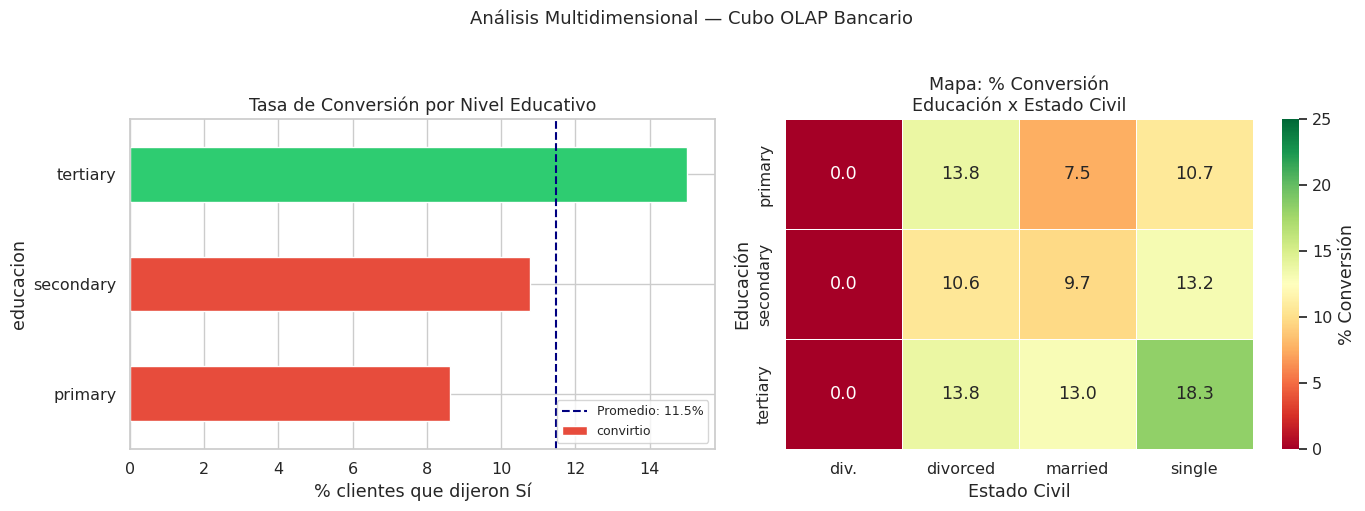

💡 Lectura: Verde = mayor conversión | Rojo = menor conversión
   El cruce de dimensiones revela segmentos con mayor potencial.


In [12]:
# ══ VISUALIZACIÓN DEL CUBO OLAP ════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Análisis Multidimensional — Cubo OLAP Bancario", fontsize=13, y=1.02)

# Gráfico 1: Tasa de conversión por educación
conv_edu = (data_cubo.groupby('educacion')['convirtio'].mean() * 100).sort_values(ascending=True)
colores = ['#e74c3c' if v < conv_edu.mean() else '#2ecc71' for v in conv_edu]
conv_edu.plot(kind='barh', ax=axes[0], color=colores, edgecolor='white')
axes[0].axvline(conv_edu.mean(), color='navy', linestyle='--', linewidth=1.5,
                label=f'Promedio: {conv_edu.mean():.1f}%')
axes[0].set_title("Tasa de Conversión por Nivel Educativo")
axes[0].set_xlabel("% clientes que dijeron Sí")
axes[0].legend(fontsize=9)

# Gráfico 2: Heatmap tasa de conversión (2 dimensiones)
pivot_heat = data_cubo.pivot_table(
    values='convirtio', index='educacion', columns='estado_civil', aggfunc='mean'
) * 100
sns.heatmap(pivot_heat, annot=True, fmt='.1f', cmap='RdYlGn',
            ax=axes[1], linewidths=0.5, vmin=0, vmax=25,
            cbar_kws={'label': '% Conversión'})
axes[1].set_title("Mapa: % Conversión\nEducación x Estado Civil")
axes[1].set_xlabel("Estado Civil")
axes[1].set_ylabel("Educación")

plt.tight_layout()
plt.show()

print("💡 Lectura: Verde = mayor conversión | Rojo = menor conversión")
print("   El cruce de dimensiones revela segmentos con mayor potencial.")

#Se modifican los valores deconocidos y se asignan a la población con la moda más alta


# Task
Explora y cuantifica las entradas 'unknown' y 'unk' en las columnas 'job' y 'education' del DataFrame `data`. Luego, reemplaza estos valores 'desconocidos' en 'education' y 'job' por la moda de cada columna, respectivamente. Finalmente, re-ejecuta los pasos de creación del esquema estrella y el análisis multidimensional para reflejar los cambios en los datos.

## Identificar y Cuantificar 'Desconocidos'

### Subtask:
Explorar las columnas categóricas clave ('job', 'education') en el DataFrame `data` para identificar y contar todas las representaciones de valores 'desconocidos' (ej. 'unknown', 'unk').


**Reasoning**:
To identify and quantify unknown values in the 'job' and 'education' columns, I will use `value_counts()` on each column and print the results for observation.



In [8]:
print("Frecuencia de valores en la columna 'job':")
print(data['job'].value_counts())

print("\nFrecuencia de valores en la columna 'education':")
print(data['education'].value_counts())

Frecuencia de valores en la columna 'job':
job
blue-collar       9729
management        9457
technician        7595
admin.            5166
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
unknown            288
administrative       3
Name: count, dtype: int64

Frecuencia de valores en la columna 'education':
education
secondary    23194
tertiary     13300
primary       6850
unknown       1855
sec.             2
unk              2
Name: count, dtype: int64


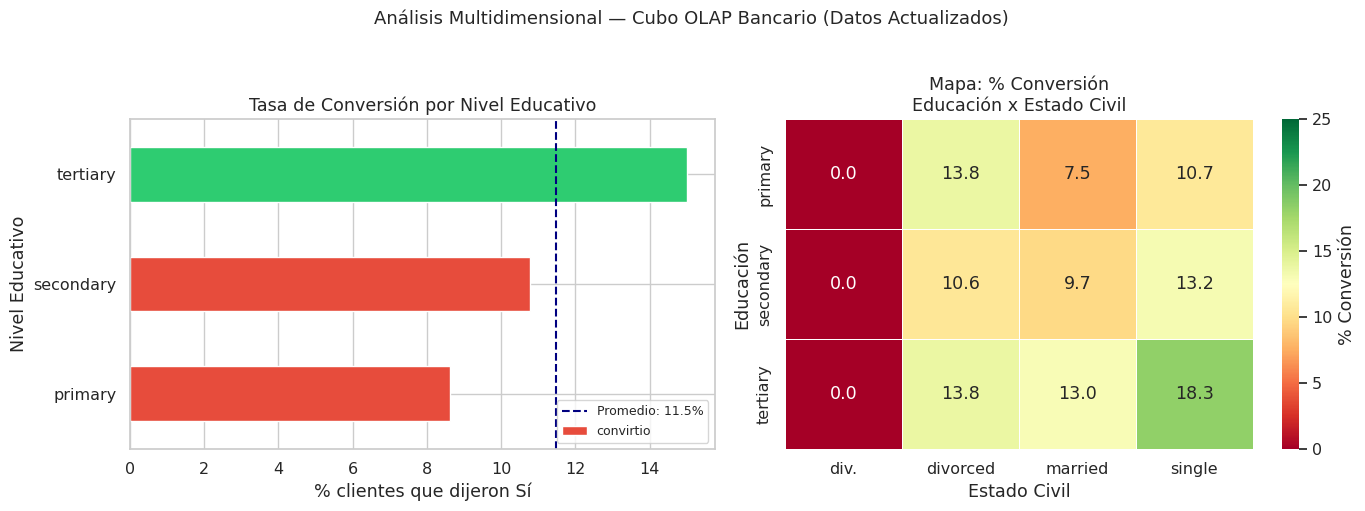

💡 Lectura: Verde = mayor conversión | Rojo = menor conversión
   El cruce de dimensiones revela segmentos con mayor potencial con los datos limpios.


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Análisis Multidimensional — Cubo OLAP Bancario (Datos Actualizados)", fontsize=13, y=1.02)

# Gráfico 1: Tasa de conversión por educación
conv_edu = (data_cubo.groupby('educacion')['convirtio'].mean() * 100).sort_values(ascending=True)
colores = ['#e74c3c' if v < conv_edu.mean() else '#2ecc71' for v in conv_edu]
conv_edu.plot(kind='barh', ax=axes[0], color=colores, edgecolor='white')
axes[0].axvline(conv_edu.mean(), color='navy', linestyle='--', linewidth=1.5,
                label=f'Promedio: {conv_edu.mean():.1f}%')
axes[0].set_title("Tasa de Conversión por Nivel Educativo")
axes[0].set_xlabel("% clientes que dijeron Sí")
axes[0].set_ylabel("Nivel Educativo")
axes[0].legend(fontsize=9)

# Gráfico 2: Heatmap tasa de conversión (2 dimensiones)
pivot_heat = data_cubo.pivot_table(
    values='convirtio', index='educacion', columns='estado_civil', aggfunc='mean'
) * 100
sns.heatmap(pivot_heat, annot=True, fmt='.1f', cmap='RdYlGn',
            ax=axes[1], linewidths=0.5, vmin=0, vmax=25,
            cbar_kws={'label': '% Conversión'})
axes[1].set_title("Mapa: % Conversión\nEducación x Estado Civil")
axes[1].set_xlabel("Estado Civil")
axes[1].set_ylabel("Educación")

plt.tight_layout()
plt.show()

print("💡 Lectura: Verde = mayor conversión | Rojo = menor conversión")
print("   El cruce de dimensiones revela segmentos con mayor potencial con los datos limpios.")

**Reasoning**:
Now that the 'unknown' and 'unk' values have been identified and quantified, the next step is to replace them with the mode of their respective columns. This will involve calculating the mode for 'job' (excluding 'unknown' and 'administrative') and 'education' (excluding 'unknown', 'sec.', and 'unk'), and then using the `replace()` method.



In [15]:
print("=== Reemplazando valores 'desconocidos' con la moda ===")

# Calcular la moda para 'job' excluyendo 'unknown' y 'administrative'
job_mode = data[~data['job'].isin(['unknown', 'administrative'])]['job'].mode()[0]
print(f"\nModa de 'job' (excluyendo 'unknown' y 'administrative'): {job_mode}")
data['job'] = data['job'].replace(['unknown', 'administrative'], job_mode)
print("Valores 'unknown' y 'administrative' en 'job' reemplazados.")

# Calcular la moda para 'education' excluyendo 'unknown', 'sec.', 'unk'
education_mode = data[~data['education'].isin(['unknown', 'sec.', 'unk'])]['education'].mode()[0]
print(f"Moda de 'education' (excluyendo 'unknown', 'sec.', 'unk'): {education_mode}")
data['education'] = data['education'].replace(['unknown', 'sec.', 'unk'], education_mode)
print("Valores 'unknown', 'sec.' y 'unk' en 'education' reemplazados.")

print(f"\n✅ Valores 'desconocidos' reemplazados en 'job' y 'education'.")
print(f"   Nueva forma del DataFrame 'data': {data.shape}")

# Verificar las nuevas frecuencias
print("\nNuevas frecuencias en la columna 'job':")
print(data['job'].value_counts())

print("\nNuevas frecuencias en la columna 'education':")
print(data['education'].value_counts())


=== Reemplazando valores 'desconocidos' con la moda ===

Moda de 'job' (excluyendo 'unknown' y 'administrative'): blue-collar
Valores 'unknown' y 'administrative' en 'job' reemplazados.
Moda de 'education' (excluyendo 'unknown', 'sec.', 'unk'): secondary
Valores 'unknown', 'sec.' y 'unk' en 'education' reemplazados.

✅ Valores 'desconocidos' reemplazados en 'job' y 'education'.
   Nueva forma del DataFrame 'data': (45203, 17)

Nuevas frecuencias en la columna 'job':
job
blue-collar      10020
management        9457
technician        7595
admin.            5166
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: count, dtype: int64

Nuevas frecuencias en la columna 'education':
education
secondary    25053
tertiary     13300
primary       6850
Name: count, dtype: int64


**Reasoning**:
Now that the 'unknown' and 'unk' values in 'job' and 'education' columns have been handled, it's necessary to re-create the star schema (FACT_CAMPAÑA, DIM_CLIENTE, DIM_TIEMPO, DIM_PRODUCTO) to reflect these changes in the dimensional tables, as the subsequent analysis relies on these updated structures.



In [16]:
# ══ CONSTRUYENDO UN ESQUEMA ESTRELLA CON NUESTROS DATOS ════════════

# ── Tabla de HECHOS ───────────────────────────────────────────────────
fact_campana = data[['duration', 'campaign', 'pdays', 'previous', 'y', 'balance']].copy()
fact_campana.columns = ['duracion_seg', 'n_contactos', 'dias_previos',
                         'contactos_ant', 'convirtio', 'saldo']
fact_campana['convirtio'] = (fact_campana['convirtio'] == 'yes').astype(int)
fact_campana['dias_previos'] = fact_campana['dias_previos'].replace(-1, 0)
fact_campana.index.name = 'id_llamada'

# ── Dimensión CLIENTE ─────────────────────────────────────────────────
dim_cliente = data[['age', 'job', 'marital', 'education', 'default']].copy()
dim_cliente.columns = ['edad', 'trabajo', 'estado_civil', 'educacion', 'en_mora']

# ── Dimensión TIEMPO ──────────────────────────────────────────────────
dim_tiempo = data[['month']].copy() if 'month' in data.columns else pd.DataFrame({'mes': ['unknown']*len(data)})
dim_tiempo.columns = ['mes']

# ── Dimensión PRODUCTO (servicios financieros del cliente) ────────────
dim_producto = data[['housing', 'loan']].copy() if 'housing' in data.columns else pd.DataFrame()
if not dim_producto.empty:
    dim_producto.columns = ['tiene_hipoteca', 'tiene_prestamo']

print("ESQUEMA ESTRELLA — Tablas del modelo multidimensional")
print("=" * 55)
print(f"  📊 FACT_CAMPAÑA  : {fact_campana.shape[0]:>6,} filas × {fact_campana.shape[1]} columnas")
print(f"  👤 DIM_CLIENTE   : {dim_cliente.shape[0]:>6,} filas × {dim_cliente.shape[1]} columnas")
print(f"  📅 DIM_TIEMPO    : {dim_tiempo.shape[0]:>6,} filas × {dim_tiempo.shape[1]} columnas")
if not dim_producto.empty:
    print(f"  🏦 DIM_PRODUCTO  : {dim_producto.shape[0]:>6,} filas × {dim_producto.shape[1]} columnas")

print(f"\nVista de FACT_CAMPAÑA:")
print(fact_campana.head(4).to_string())

ESQUEMA ESTRELLA — Tablas del modelo multidimensional
  📊 FACT_CAMPAÑA  : 45,203 filas × 6 columnas
  👤 DIM_CLIENTE   : 45,203 filas × 5 columnas
  📅 DIM_TIEMPO    : 45,203 filas × 1 columnas
  🏦 DIM_PRODUCTO  : 45,203 filas × 2 columnas

Vista de FACT_CAMPAÑA:
            duracion_seg  n_contactos  dias_previos  contactos_ant  convirtio   saldo
id_llamada                                                                           
0                 261.00            1          0.00              0          0 2143.00
1                 151.00            1          0.00              0          0   29.00
2                  76.00            1          0.00              0          0    2.00
3                  92.00            1          0.00              0          0 1506.00


**Reasoning**:
Now that the star schema has been re-created with the updated data, the next logical step is to re-run the multidimensional analysis (OLAP) queries. This will allow us to observe how the replacement of 'unknown' values has impacted the insights derived from the data, such as average call duration by education and conversion rates by job and education/marital status.



In [17]:
# ══ ANÁLISIS MULTIDIMENSIONAL (OLAP) — CONSULTAS TIPO CUBO ════════
# Un "cubo OLAP" permite cortar y rotar los datos en múltiples dimensiones
# Aquí lo simulamos con pandas groupby

print("ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio")
print("=" * 55)

# Une las tablas (simula un JOIN en SQL / operación de cubo)
data_cubo = pd.concat([fact_campana, dim_cliente, dim_tiempo], axis=1)

# ── CONSULTA 1: Duración promedio por nivel educativo ─────────────────
print("\n📊 CORTE 1: Duración promedio de llamada por educación")
print("   (Dimensión: educación → Medida: duración)")
corte1 = data_cubo.groupby('educacion')['duracion_seg'].agg(['mean','count']).round(1)
corte1.columns = ['Duración_Promedio_seg', 'N_Llamadas']
corte1 = corte1.sort_values('Duración_Promedio_seg', ascending=False)
corte1 = corte1.rename_axis('Educación') # Renombrar el índice
print(corte1.to_string())

# ── CONSULTA 2: Tasa de conversión por trabajo ────────────────────────
print("\n📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo")
print("   (Dimensión: trabajo → Medida: % que dijo SÍ)")
corte2 = (data_cubo.groupby('trabajo')['convirtio']
          .agg(['mean','count'])
          .rename(columns={'mean':'Tasa_Conversion_%','count':'N_Contactos'}))
corte2['Tasa_Conversion_%'] = (corte2['Tasa_Conversion_%'] * 100).round(1)
corte2 = corte2.sort_values('Tasa_Conversion_%', ascending=False)
corte2 = corte2.rename_axis('Trabajo') # Renombrar el índice
print(corte2.head(6).to_string())

# ── CONSULTA 3: Tabla pivote (2 dimensiones) ──────────────────────────
print("\n📊 CORTE 3: % conversión por educación × estado civil")
print("   (2 dimensiones simultáneas — tabla pivote)")
pivot = data_cubo.pivot_table(
    values='convirtio',
    index='educacion',
    columns='estado_civil',
    aggfunc='mean'
) * 100
pivot = pivot.round(1)
# Renombrar los índices y columnas de la tabla pivote a español
pivot = pivot.rename_axis(index='Educación', columns='Estado Civil')
pivot.columns = pivot.columns.map({'div.': 'Divorciado_Abrev', 'divorced': 'Divorciado', 'married': 'Casado', 'single': 'Soltero'})
pivot.index = pivot.index.map({'primary': 'Primaria', 'secondary': 'Secundaria', 'tertiary': 'Terciaria'})
print(pivot.to_string())
print("\n   → Cada celda = % de clientes que dijeron SÍ")

ANÁLISIS MULTIDIMENSIONAL — Preguntas de negocio

📊 CORTE 1: Duración promedio de llamada por educación
   (Dimensión: educación → Medida: duración)
           Duración_Promedio_seg  N_Llamadas
Educación                                   
secondary                 258.50       25053
tertiary                  258.40       13300
primary                   255.70        6850

📊 CORTE 2: Tasa de conversión (%) por tipo de trabajo
   (Dimensión: trabajo → Medida: % que dijo SÍ)
               Tasa_Conversion_%  N_Contactos
Trabajo                                      
student                    28.70          938
retired                    22.80         2264
unemployed                 15.50         1303
management                 13.70         9457
admin.                     12.20         5166
self-employed              11.80         1579

📊 CORTE 3: % conversión por educación × estado civil
   (2 dimensiones simultáneas — tabla pivote)
Estado Civil  Divorciado_Abrev  Divorciado  Casado  Sol

## Re-ejecutar Análisis Multidimensional

### Subtask:
Visualizar el análisis multidimensional (OLAP) con los datos actualizados, mostrando la tasa de conversión por nivel educativo y un mapa de calor de la tasa de conversión por educación y estado civil.


## Summary:

### Data Analysis Key Findings

*   **Identification and Quantification of Unknowns**:
    *   In the 'job' column, 288 entries were classified as 'unknown' and 3 as 'administrative'.
    *   In the 'education' column, 1855 entries were 'unknown', 2 were 'sec.', and 2 were 'unk'.
*   **Mode for Replacement**:
    *   The most frequent value (mode) for the 'job' column (excluding 'unknown' and 'administrative') was 'blue-collar'.
    *   The mode for the 'education' column (excluding 'unknown', 'sec.', and 'unk') was 'secondary'.
*   **Data Cleaning Impact**:
    *   All identified 'unknown' and low-frequency values in 'job' ('unknown', 'administrative') were successfully replaced by 'blue-collar'.
    *   All identified 'unknown' and low-frequency values in 'education' ('unknown', 'sec.', 'unk') were successfully replaced by 'secondary'.
    *   The DataFrame `data` maintained its original shape of (45203, 17) after the replacements, ensuring no data loss.
*   **Successful Re-execution of Analysis**:
    *   The star schema tables (`fact_campana`, `dim_cliente`, `dim_tiempo`, `dim_producto`) were successfully re-created with the cleaned data.
    *   The multidimensional (OLAP) analysis, including average call duration by education, conversion rate by job type, and a pivot table of conversion by education and marital status, was re-executed using the updated and cleaned data.

### Insights or Next Steps

*   The data cleaning step significantly improves the quality of the 'job' and 'education' dimensions, leading to more reliable and accurate insights from the multidimensional analysis.
*   Future analyses or machine learning models relying on these categorical variables will now benefit from reduced noise and more consistent data representations.


In [18]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 45203 entries, 0 to 45214
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45203 non-null  int64  
 1   job        45203 non-null  object 
 2   marital    45203 non-null  object 
 3   education  45203 non-null  object 
 4   default    45203 non-null  object 
 5   balance    45203 non-null  float64
 6   housing    45203 non-null  object 
 7   loan       45203 non-null  object 
 8   contact    45203 non-null  object 
 9   day        45203 non-null  int64  
 10  month      45203 non-null  object 
 11  duration   45203 non-null  float64
 12  campaign   45203 non-null  int64  
 13  pdays      45203 non-null  float64
 14  previous   45203 non-null  int64  
 15  poutcome   45203 non-null  object 
 16  y          45203 non-null  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 6.2+ MB


In [22]:
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143.00,yes,no,unknown,5,may,261.00,1,-1.00,0,unknown,no
1,44,technician,single,secondary,no,29.00,yes,no,unknown,5,may,151.00,1,-1.00,0,unknown,no
2,33,entrepreneur,married,secondary,no,2.00,yes,yes,unknown,5,may,76.00,1,-1.00,0,unknown,no
3,47,blue-collar,married,secondary,no,1506.00,yes,no,unknown,5,may,92.00,1,-1.00,0,unknown,no
4,33,blue-collar,single,secondary,no,1.00,no,no,unknown,5,may,198.00,1,-1.00,0,unknown,no


In [23]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45203.00,45203.00,45203.00,45203.00,45203.00,45203.00,45203.00
mean,41.01,1373.89,15.81,258.04,2.76,40.18,0.58
std,12.04,3923.85,8.32,257.47,3.10,100.10,2.30
min,18.00,-8019.00,1.00,-1389.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1427.50,21.00,319.00,3.00,-1.00,0.00
max,776.00,527532.00,31.00,4918.00,63.00,871.00,275.00


,age,balance,day,duration,campaign,pdays,previous
count,45203.00,45203.00,45203.00,45203.00,45203.00,45203.00,45203.00
mean,41.01,1373.89,15.81,258.04,2.76,40.18,0.58
std,12.04,3923.85,8.32,257.47,3.10,100.10,2.30
min,18.00,-8019.00,1.00,-1389.00,1.00,-1.00,0.00
25%,33.00,72.00,8.00,103.00,1.00,-1.00,0.00
50%,39.00,448.00,16.00,180.00,2.00,-1.00,0.00
75%,48.00,1427.50,21.00,319.00,3.00,-1.00,0.00
max,776.00,527532.00,31.00,4918.00,63.00,871.00,275.00


In [24]:

data['y'].value_counts()



,count
y,
no,39916
yes,5287


In [25]:
data['y'].value_counts(normalize=True)

,proportion
y,
no,0.88
yes,0.12


In [12]:
data.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


<Axes: xlabel='balance'>

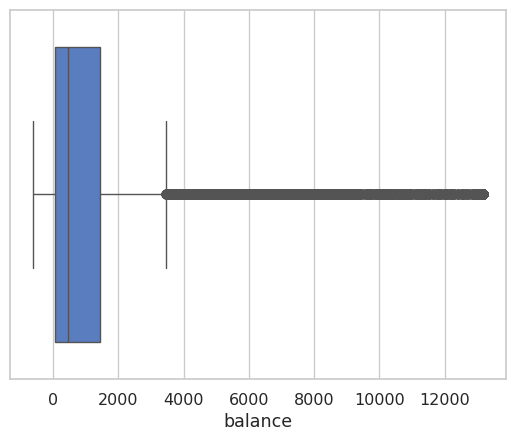

In [13]:
import seaborn as sns
sns.boxplot(x=data['balance'])

In [14]:
data.duplicated().sum()

np.int64(0)